In [114]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [115]:
cd /gdrive/My\ Drive

/gdrive/My Drive


In [116]:
cd Biomedical_Assignment3_submission_EE19S042/

/gdrive/My Drive/Biomedical_Assignment3_submission_EE19S042


In [117]:
!pip install PyMaxflow

In [118]:
#usage of PyMaxflow which can do the graph cut efficiently using Kolmogorov's C++ implementation
import maxflow as mf
import numpy as np
import time
import sys 
import os.path
import matplotlib.pyplot as plt
import cv2
import math
from pathlib import Path
from google.colab import files
from random import shuffle
from PIL import Image
from maxflow.fastmin import aexpansion_grid

Image number to be segmented between 1 to 20:4


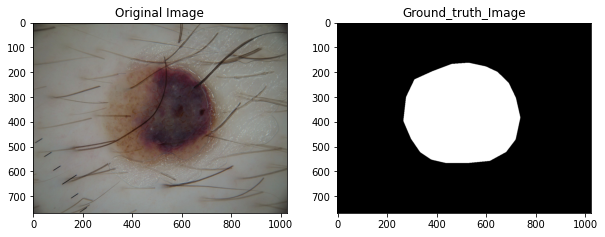

In [119]:
list_img_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.jpg'))
list_segmentation_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.png'))
img_no=input("Image number to be segmented between 1 to 20:")
img_no=int(img_no)-1
Original_Image=plt.imread(str(list_img_names[img_no]))
gt_img = plt.imread(str(list_segmentation_names[img_no]))
# Display results
display = [Original_Image, gt_img]
label = ['Original Image', 'Ground_truth_Image']
fig = plt.figure(figsize=(10,10))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig.add_subplot(2,2, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

In [120]:
def rgb2gray(img):
    gray = np.dot(img[:,:,0],0.2989) + np.dot(img[:,:,1],0.5870) + np.dot(img[:,:,2],0.1140)
    return gray

def hist_freq_filter(beta_frq,peak_intensity_smooth_1,pit_intensity_smooth_1, peak_frequency_smooth_1,pit_frequency_smooth_1):
    HD = np.abs(np.array(peak_frequency_smooth_1)-np.array(pit_frequency_smooth_1))
    thresh_frq = np.mean(HD)*beta_frq
    ind1 = np.where(HD<thresh_frq)
    peak_intensity_smooth_2 = np.delete(np.array(peak_intensity_smooth_1),ind1[0])
    pit_intensity_smooth_2 = np.delete(np.array(pit_intensity_smooth_1),ind1[0])
    peak_frequency_smooth_2 = np.delete(np.array(peak_frequency_smooth_1),ind1[0])
    pit_frequency_smooth_2 = np.delete(np.array(pit_frequency_smooth_1),ind1[0])
    return list(peak_intensity_smooth_2), list(pit_intensity_smooth_2), list(peak_frequency_smooth_2), list(pit_frequency_smooth_2)




def hist_intensity_filter(beta_in,peak_intensity,pit_intensity,peak_frequency,pit_frequency):
    LD = np.abs(np.array(peak_intensity)-np.array(pit_intensity))
    thresh_in = np.mean(LD)*beta_in
    # if thresh_in> 4: thresh_in=3
    ind = np.where(LD<thresh_in)
    peak_intensity_smooth_1 = np.delete(np.array(peak_intensity),ind[0])
    pit_intensity_smooth_1 = np.delete(np.array(pit_intensity),ind[0])
    peak_frequency_smooth_1 = np.delete(np.array(peak_frequency),ind[0])
    pit_frequency_smooth_1 = np.delete(np.array(pit_frequency),ind[0])
    return list(peak_intensity_smooth_1), list(pit_intensity_smooth_1), list(peak_frequency_smooth_1), list(pit_frequency_smooth_1)

In [121]:
def modf_peak_pit_intensity(peak_intensity,pit_intensity):
    peak_intensity, pit_intensity =peak_intensity_init,pit_intensity_init
    if pit_intensity[0]<peak_intensity[0]:
        peak_array=np.concatenate((np.array(peak_intensity)[:,np.newaxis],
        np.ones((len(peak_intensity),1))),axis=1)
        pit_array=np.concatenate((np.array(pit_intensity)[:,np.newaxis],
        np.zeros((len(pit_intensity),1))),axis=1)
    else:
        peak_array=np.concatenate((np.array(peak_intensity)[:,np.newaxis],
        np.zeros((len(peak_intensity),1))),axis=1)
        pit_array=np.concatenate((np.array(pit_intensity)[:,np.newaxis],
        np.ones((len(pit_intensity),1))),axis=1)
    array = np.concatenate((pit_array,peak_array),axis=0)
    ind = np.argsort(array[:,0])
    ind_arr = np.concatenate((ind[:,np.newaxis],ind[:,np.newaxis]),axis=1)
    srtd_array = np.take_along_axis(array,ind_arr,axis=0)
    srtd_array = srtd_array.astype('int')
#     print(srtd_array)
    srtd_array_modf = srtd_array

    for i in range(0,len(srtd_array[:,1])):
        if i==0:
            val=srtd_array[:,1][i]
        else:
            if (val==0 and srtd_array[:,1][i]==1) or (val==1 and srtd_array[:,1][i]==0):
                val=srtd_array[:,1][i]

            elif val==0 and srtd_array[:,1][i]==0:            
                val=srtd_array[:,1][i]
                srtd_array_modf[:,1][i-1]=2

            elif val==1 and srtd_array[:,1][i]==1:
                val=srtd_array[:,1][i]
                srtd_array_modf[:,1][i]=2
    ii=np.where(srtd_array[:,1]==2)
    srtd_array_mod = np.delete(srtd_array_modf,ii[0],axis=0)
#     print(srtd_array_mod)
    if pit_intensity[0]<peak_intensity[0]:
        pit_intensity_modf =[srtd_array_mod[i,0] for i in range(0,len(srtd_array_mod)) if i%2==0]
        peak_intensity_modf =[srtd_array_mod[i,0] for i in range(0,len(srtd_array_mod)) if i%2!=0]

    else:    
        peak_intensity_modf =[srtd_array_mod[i,0] for i in range(0,len(srtd_array_mod)) if i%2==0]
        pit_intensity_modf =[srtd_array_mod[i,0] for i in range(0,len(srtd_array_mod)) if i%2!=0] 
    return peak_intensity_modf,pit_intensity_modf

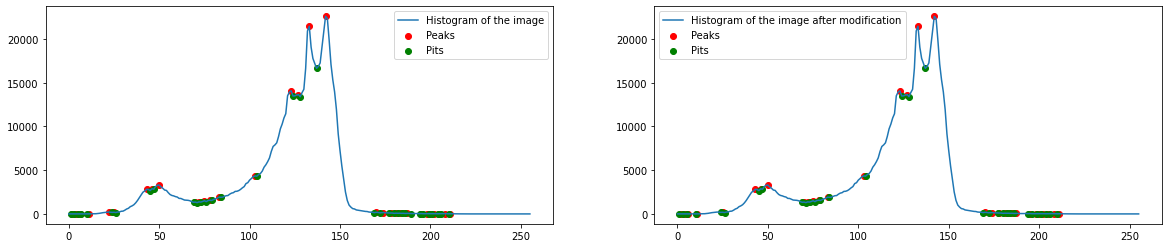

In [122]:

list_img_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.jpg'))
list_segmentation_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.png'))
#img = plt.imread(str(list_img_names[0]))
# img=plt.imread("segmented_1.png")
original_pil=Image.open(str(list_img_names[img_no]))
gray = Image.open(str(list_img_names[img_no])).convert('L')
#img = np.array(Image.open(filename))
# gray=gray.resize((int(gray.size[0]/2),int(gray.size[1]/2)))
#gray=np.array(gray)

# # # grey_levels, count = np.unique(gray, return_counts=True)
# # img_name_a="segmented_1.png"
# # #img_name_a="testimages/Leopard/leopard_250_10percent"
# # cycles=int(2)
# # from PIL import Image
# # gray = Image.open(img_name_a).convert('L')
grey_levels, count = np.unique(gray, return_counts=True)
H = np.zeros((256,1))
for i in range(0,len(grey_levels)):
    H[i,0]=count[i]
peak_intensity_init = [p for p in range(1,H.shape[0]-1) if H[p-1]<H[p] and H[p]>H[p+1]]
pit_intensity_init = [p for p in range(1,H.shape[0]-1) if H[p-1]>H[p] and H[p]<H[p+1]]
peak_intensity,pit_intensity = modf_peak_pit_intensity(peak_intensity_init,pit_intensity_init)
if len(peak_intensity)!= len(pit_intensity):
      if (peak_intensity[0] < pit_intensity[0]):
         peak_intensity=peak_intensity[1:len(peak_intensity)]
      elif (peak_intensity[0] > pit_intensity[0]):
         pit_intensity=pit_intensity[1:len(pit_intensity)]
# if len(peak_intensity)>len(pit_intensity):
#     peak_intensity = peak_intensity[0:-1]
# elif len(peak_intensity)<len(pit_intensity):
#     pit_intensity = pit_intensity[0:-1]
peak_frequency_init = [H[p] for p in peak_intensity_init]
pit_frequency_init = [H[p] for p in pit_intensity_init]
peak_frequency = [H[p] for p in peak_intensity]
pit_frequency = [H[p] for p in pit_intensity]

# fg = plt.figure(figsize=(12,15))
fg = plt.figure("Regularised labeling",figsize=(20,4))
ax1 = fg.add_subplot(1,2,1)
ax1.plot(H,label='Histogram of the image')
ax1.scatter(peak_intensity_init,peak_frequency_init,c='r',label='Peaks')
ax1.scatter(pit_intensity_init,pit_frequency_init,c='g',label='Pits')
ax1.legend()
ax2 = fg.add_subplot(1,2,2)
ax2.plot(H,label='Histogram of the image after modification')
ax2.scatter(peak_intensity,peak_frequency,c='r',label='Peaks')
ax2.scatter(pit_intensity,pit_frequency,c='g',label='Pits')
ax2.legend()

In [123]:
# thresh_in

In [124]:
beta_in = 0.5

peak_intensity_smooth_1, pit_intensity_smooth_1, peak_frequency_smooth_1, pit_frequency_smooth_1 = hist_intensity_filter(beta_in,peak_intensity,pit_intensity,peak_frequency,pit_frequency)

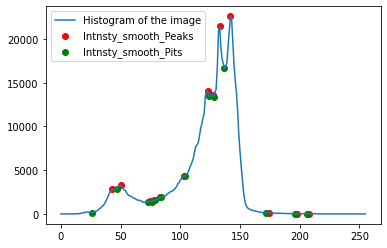

In [125]:

plt.plot(H,label='Histogram of the image')
plt.scatter(peak_intensity_smooth_1,peak_frequency_smooth_1,c='r',label='Intnsty_smooth_Peaks')
plt.scatter(pit_intensity_smooth_1,pit_frequency_smooth_1,c='g',label='Intnsty_smooth_Pits')
plt.legend()

In [126]:
beta_frq =0.1
print("Bita frequency:%f"%beta_frq)
peak_intensity_smooth_2, pit_intensity_smooth_2, peak_frequency_smooth_2, pit_frequency_smooth_2 = hist_freq_filter(beta_frq,peak_intensity_smooth_1,pit_intensity_smooth_1 , peak_frequency_smooth_1,pit_frequency_smooth_1)

Bita frequency:0.100000


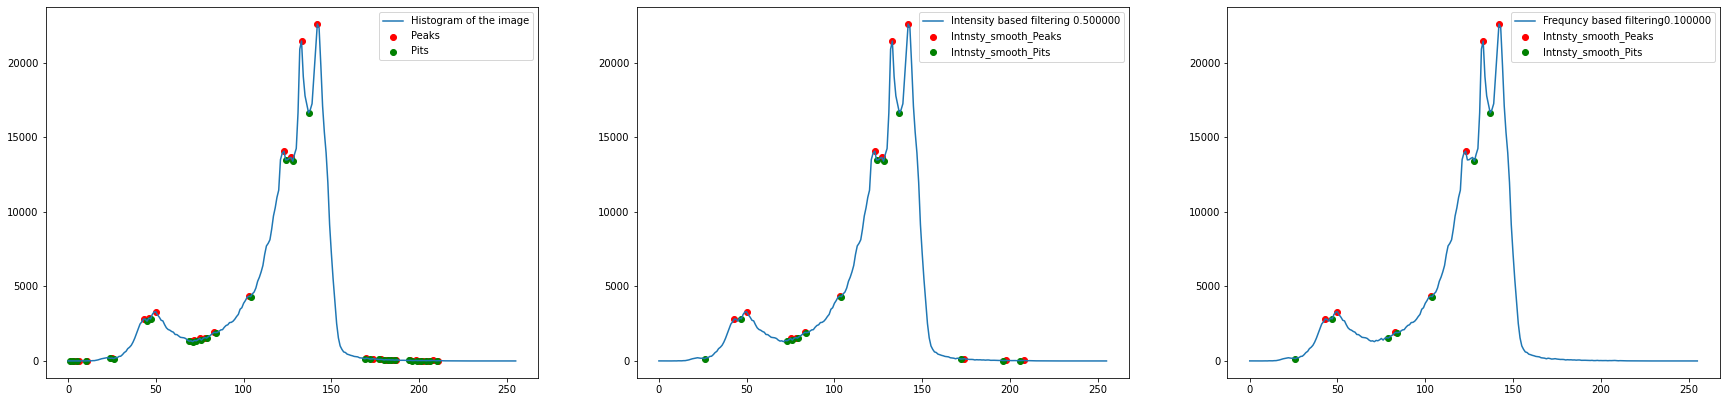

In [127]:
#fig = plt.figure(figsize=(15,15))
fg = plt.figure("Regularised labeling",figsize=(30,15))
ax1 = fg.add_subplot(2,3,1)
ax1.plot(H,label='Histogram of the image')
ax1.scatter(peak_intensity,peak_frequency,c='r',label='Peaks')
ax1.scatter(pit_intensity,pit_frequency,c='g',label='Pits')
ax1.legend()
ax2 = fg.add_subplot(2,3,2)
ax2.plot(H,label='Intensity based filtering %f'%beta_in)
ax2.scatter(peak_intensity_smooth_1,peak_frequency_smooth_1,c='r',label='Intnsty_smooth_Peaks')
ax2.scatter(pit_intensity_smooth_1,pit_frequency_smooth_1,c='g',label='Intnsty_smooth_Pits')
ax2.legend()
ax3 = fg.add_subplot(2,3,3)
ax3.plot(H,label='Frequncy based filtering%f'%beta_frq)
ax3.scatter(peak_intensity_smooth_2,peak_frequency_smooth_2,c='r',label='Intnsty_smooth_Peaks')
ax3.scatter(pit_intensity_smooth_2,pit_frequency_smooth_2,c='g',label='Intnsty_smooth_Pits')
ax3.legend()
# plt.plot(H,label='Histogram of the image')
# plt.scatter(peak_intensity_smooth_2,peak_frequency_smooth_2,c='r',label='Intnsty_smooth_Peaks')
# plt.scatter(pit_intensity_smooth_2,pit_frequency_smooth_2,c='g',label='Intnsty_smooth_Pits')
# plt.legend()
# fg.savefig("Output/op%d/Histogram plot ouput.png"%int(img_no+1))

# files.download("Output/op%d/Histogram plot ouput.png"%int(img_no+1))

In [128]:
peak_intensity_smooth_2, pit_intensity_smooth_2, peak_frequency_smooth_2, pit_frequency_smooth_2

([43, 50, 83, 103, 123, 133, 142],
 [26, 47, 79, 84, 104, 128, 137],
 [2814.0, 3294.0, 1910.0, 4338.0, 14071.0, 21453.0, 22596.0],
 [158.0, 2822.0, 1536.0, 1902.0, 4316.0, 13400.0, 16643.0])

In [129]:
cluster_number=len(peak_intensity_smooth_2)+len(pit_intensity_smooth_2)
if (cluster_number<7):
     print(cluster_number)
peak_frrequency_smooth_2_asnd=peak_frequency_smooth_2
pit_frrequency_smooth_2_asnd=pit_frequency_smooth_2
peak_frrequency_smooth_2_asnd.sort()
#print(peak_frrequency_smooth_2_asnd)
pit_frrequency_smooth_2_asnd.sort()

if (peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-2])>8000:
    print(peak_frrequency_smooth_2_asnd[-1])
    print('Hi!')
if (peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-2])<1000:
     print(peak_frequency_smooth_2[-1]-peak_frequency_smooth_2[-2])
if (peak_frrequency_smooth_2_asnd[1]-peak_frrequency_smooth_2_asnd[0])<10000:
    if (peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-2])<10000:
      print(peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-2])
      if (max(peak_intensity_smooth_2)<130):
        print(peak_intensity_smooth_2)
        print('Hi!!there')

1143.0


In [130]:
seg_img = np.array(gray)
seg_img[:,:] =0
cluster_number=len(peak_intensity_smooth_2)+len(pit_intensity_smooth_2)
# start_thresh=min(peak_intensity_smooth_2[0],pit_intensity_smooth_2[0])
avg=int(abs(max(peak_intensity_smooth_2)-pit_intensity_smooth_2[1])/2)
if (cluster_number<7):
    ind = np.where(gray>(pit_intensity_smooth_2[0]))   #Back ground
                  #& (gray<=160))
    ind1 = np.where((gray>pit_intensity_smooth_2[0]) &  (gray<=peak_intensity_smooth_2[-1])) # fore ground
    if (peak_intensity_smooth_2[0]<pit_intensity_smooth_2[0]):
       ind1 = np.where((gray>abs((peak_intensity_smooth_2[0])-(peak_intensity_smooth_2[0]))) &  (gray<=(max(peak_intensity_smooth_2))-20)) # fore ground# obstacles(like hair)
#        ind = np.where((gray>(max(peak_intensity_smooth_2))-20))
       print('Hi!!there,loop1')
    if (pit_frequency_smooth_2[1]-pit_frequency_smooth_2[0])<5000:
        if (peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-2])<10000:
            ind = np.where((gray>(max(peak_intensity_smooth_2))))   #Back ground
                  #& (gray<=160))
            #ind1 = np.where((gray<=(peak_intensity_smooth_2[-2])) &  (gray<=(max(peak_intensity_smooth_2))))
            print('Hi!!there,loop2')
            ind1 = np.where((gray>(pit_intensity_smooth_2[0]-pit_intensity_smooth_2[0])) &  (gray<=(max(peak_intensity_smooth_2))+60)) #foreground
            if peak_intensity_smooth_2[-1]<120:
                  ind = np.where((gray>max(peak_intensity_smooth_2)+60))   #Back ground
                  #& (gray<=160))
                  print('Hi!!there,loop3')
                  #ind1 = np.where((gray<=(peak_intensity_smooth_2[-2]-20)) &  (gray<=(max(peak_intensity_smooth_2))))
                  ind1 = np.where((gray>(pit_intensity_smooth_2[0]-pit_intensity_smooth_2[0])) &  (gray<=(peak_intensity_smooth_2[-1])+60)) #foreground
    seg_img[ind[0],ind[1]]=50  #(min(pit_intensity_smooth_2)+max(peak_intensity_smooth_2))/2 #Back ground
    seg_img[ind1[0],ind1[1]] =255  # Fore ground
else:
    ind = np.where((gray>(max(peak_intensity_smooth_2))))   #Back ground
                  #& (gray<=160))
    ind1 = np.where((gray>(peak_intensity_smooth_2[1])) &  (gray<=(max(peak_intensity_smooth_2))))
    ind2 = np.where((gray>((pit_intensity_smooth_2[0])-(pit_intensity_smooth_2[0])+20)) &  (gray<=(peak_intensity_smooth_2[1]))) #foreground
    if (pit_frequency_smooth_2[1]-pit_frequency_smooth_2[0])<10000:
        if (peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-2])<10000:
            ind = np.where((gray>(max(peak_intensity_smooth_2))))   #Back ground
                  #& (gray<=160))
            ind1 = np.where((gray<=(peak_intensity_smooth_2[-2])) &  (gray<=(max(peak_intensity_smooth_2))))
            ind2 = np.where((gray>(pit_intensity_smooth_2[0]-pit_intensity_smooth_2[0])+20) &  (gray<=(peak_intensity_smooth_2[-2]))) #foreground
            print('Hi!!there,loop4')
            if (peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-3])<10000:
              ind = np.where((gray>(max(peak_intensity_smooth_2))))   #Back ground
                  #& (gray<=160))
              ind1 = np.where((gray<=(peak_intensity_smooth_2[-2]-20)) &  (gray<=(max(peak_intensity_smooth_2))))
              ind2 = np.where((gray>(pit_intensity_smooth_2[0]-pit_intensity_smooth_2[0])+20) &  (gray<=(peak_intensity_smooth_2[-2]-20))) #foreground
            if peak_intensity_smooth_2[-1]<100:
                  ind = np.where((gray>max(peak_intensity_smooth_2)+20))   #Back ground
                  #& (gray<=160))
                  print('Hi!!there,loop5')
                  #ind1 = np.where((gray<=(peak_intensity_smooth_2[-2]-20)) &  (gray<=(max(peak_intensity_smooth_2))))
                  ind2 = np.where((gray>(pit_intensity_smooth_2[0]-pit_intensity_smooth_2[0])) &  (gray<=(peak_intensity_smooth_2[-1]))) #foreground
        else:
            ind = np.where((gray>(max(peak_intensity_smooth_2))))   #Back ground
                  #& (gray<=160))
            ind2 = np.where((gray<=(pit_intensity_smooth_2[0]-pit_intensity_smooth_2[0]+20)) &  (gray<=(max(peak_intensity_smooth_2)))) #foreground
            print('Hi!!there,loop6')

    if (peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-2])<500:
          ind = np.where((gray>(max(peak_intensity_smooth_2))))   #Back ground
                  #& (gray<=160))
          ind1 = np.where((gray<=(peak_intensity_smooth_2[-2])) &  (gray<=(max(peak_intensity_smooth_2))))
          ind2 = np.where((gray>(pit_intensity_smooth_2[0]-pit_intensity_smooth_2[0]+20)) &  (gray<=(peak_intensity_smooth_2[-2]))) #foreground
          print('Hi!!there,loop7')
    if (peak_frrequency_smooth_2_asnd[-1]-peak_frrequency_smooth_2_asnd[-2])>8000:
       ind = np.where((gray>(max(peak_intensity_smooth_2))))
       ind2 = np.where((gray>(pit_intensity_smooth_2[0])) &  (gray<=(max(peak_intensity_smooth_2))-20))
       print('Hi!!there,loop8')
       if (max(peak_intensity_smooth_2)<130):
          ind = np.where((gray>(max(peak_intensity_smooth_2))))
          ind2 = np.where((gray>(pit_intensity_smooth_2[0])) &  (gray<=(max(peak_intensity_smooth_2))+20))
          print('Hi!!there,loop9')
    if (peak_intensity_smooth_2[0]<pit_intensity_smooth_2[0]):
      ind2 = np.where((gray>abs((peak_intensity_smooth_2[0])-(peak_intensity_smooth_2[0])+20)) &  (gray<=(pit_intensity_smooth_2[1]))) # fore ground# obstacles(like hair)
      ind1 = np.where((gray>(pit_intensity_smooth_2[1])) &  (gray<=(max(peak_intensity_smooth_2))))
      ind  = np.where((gray>(max(peak_intensity_smooth_2))))
      print('Hi!!there,loop10')
      # if (peak_intensity_smooth_2[0])>50
      #      ind2 = np.where((gray>abs((peak_intensity_smooth_2[0])-30)) &  (gray<=(pit_intensity_smooth_2[1])+50)) # fore ground# obstacles(like hair)
      
    seg_img[ind[0],ind[1]]= 50#(min(pit_intensity_smooth_2)+max(peak_intensity_smooth_2))/2        #back_ground
    seg_img[ind1[0],ind1[1]] =150#(min(pit_intensity_smooth_2)+max(peak_intensity_smooth_2))/6     #(min(pit_intensity_smooth_2)+max(peak_intensity_smooth_2))/2
    seg_img[ind2[0],ind2[1]] =255   # fore ground# obstacles(like hair)
# #(gray<peak_intensity_smooth_2[1] ))
# ind2 = np.where((gray>100) & (gray<=120))
# gray[ind[0],ind[1]] 

Hi!!there,loop4


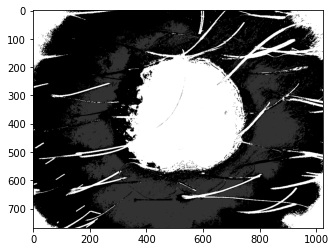

In [131]:
#Convert image to numpy array
seg_img=np.array(seg_img)
#Convert numpy array back to image 
seg_img=Image.fromarray(seg_img)
# seg_img=np.uint8(seg_img)
plt.imshow(seg_img,cmap='gray')

In [132]:
np.unique(seg_img)

array([  0,  50, 150, 255], dtype=uint8)

In [133]:
#list_segmentation_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.png'))
# gt_img = plt.imread(str(list_segmentation_names[img_no]))

Original Image /gdrive/My Drive/Biomedical_Assignment3_submission_EE19S042/27-20201003T050528Z-001/27/ISIC_0009942.jpg


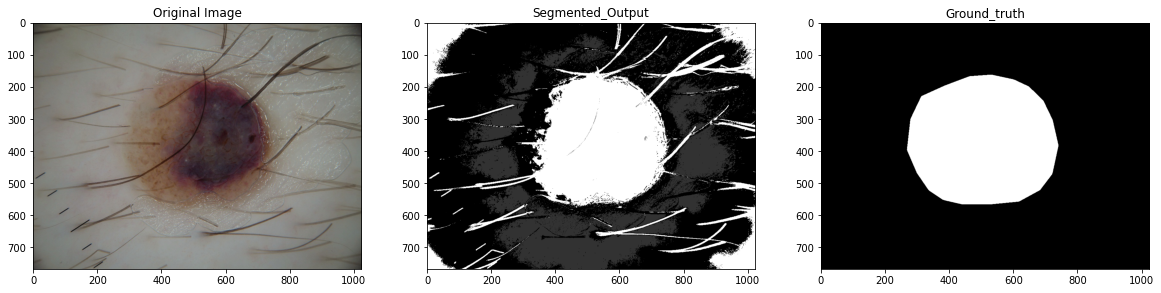

In [134]:
# # Display results
#'Histogram_plot_with peak pit detcted','Histogram_plot after intensity based filtering','Histogram_plot after frequency based filtering',
print('Original Image %s'%str(list_img_names[img_no]))
display = [original_pil,seg_img,gt_img]
label = ['Original Image', 'Segmented_Output', 'Ground_truth']
fig1 = plt.figure(figsize=(20,20))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig1.add_subplot(2,3, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

# images_dir = 'Output/op%d'%int(img_no+1)
# fig1.savefig("Output/op%d/Histogram segmentation ouput.png"%int(img_no+1))

# files.download("Output/op%d/Histogram segmentation ouput.png"%int(img_no+1))

**Part 2: Apply graph cut method to optimize the delineation of the lesion from the background using minimization algorithms: alpha-expansion and alpha-beta swap.**

In [135]:


def give_test_1d_image():
    '''returns a 1x10 pixel image'''
    return np.array([[5,5,5,2,7,7,4,7]])


def calculate_energy(img_orig, img_work):
    '''Calculates Energy of image.
       img: is input array'''

    E_data = 0
    for i in range(len(img_orig)):
        for j in range(len(img_orig[0])):
            E_data += D_p(img_orig[i][j], img_work, j, i)
    
    E_smooth = 0
    for i in range(len(img_orig)):
        for j in range(len(img_orig[0])):
            ns = give_neighbours(img_work, j, i)
            E_smooth += sum([V_p_q(v, img_work[i][j]) for v in ns])

    return E_data + E_smooth

     
def V_p_q(label1, label2):
    '''Definition of the potential'''
    # return 45*abs(label1-label2)
    return abs(label1-label2)
    # return min(10,abs(label1-label2))
    
    
def D_p(label, graph, x, y):
    '''Returns the quadratic difference between label and real intensity of pixel'''
    return (abs(label**2-graph[y][x]**2))**0.5  #best working D_p
    # return (label-graph[y][x])**2


def give_neighbours(image, x, y):
    '''Returns a list of all neighbour intensities'''
    if x>=len(image[0]) or x<0 or y>=len(image) or y<0:
       raise ValueError('Pixel is not in image. x and/or y are to large')
    ns = []
    for a,b in zip([1,0,-1,0],[0,1,0,-1]):
        if (x+a<len(image[0]) and x+a>=0) and (y+b<len(image) and y+b>=0):
            ns.append(image[y+b][x+a])
    return ns 


def return_mapping_of_image(image, alpha, beta):
    #map does the position in graph map to (y,x) position in image
    map = {}
    #other way 
    revmap = {}
    #loop over all pixels and add them to maps
    map_parameter = 0
    for y in range(len(image)):
        for x in range(len(image[0])):
            #extract pixel which have the wanted label
            if image[y][x] == alpha or image[y][x] == beta:
                map[map_parameter] = (y,x)
                revmap[(y,x)] = map_parameter
                map_parameter += 1
    
    return map, revmap


def alpha_beta_swap_new(alpha, beta, img_orig, img_work):
    ''' Performs alpha-beta-swap
        img_orig: input image 
        img_work: denoised image in each step
        time_measure: flag if you want measure time'''

    #extract position of alpha or beta pixels to mapping 
    map, revmap = return_mapping_of_image(img_work, alpha, beta)
    
    #graph of maxflow 
    graph_mf = mf.Graph[float](len(map) )
    #add nodes
    nodes = graph_mf.add_nodes(len(map))
            
    #add n-link edges
    weight = V_p_q(alpha, beta)
    for i in range(0,len(map)):
        y,x = map[i]
        #top, left, bottom, right
        for a,b in zip([1,0,-1,0],[0,1,0,-1]):
            if (y+b, x+a) in revmap:
                graph_mf.add_edge(i,revmap[(y+b,x+a)], weight, 0)
   
    #add all the terminal edges
    for i in range(0,len(map)):
        y,x = map[i]
        #find neighbours
        neighbours = give_neighbours(img_work, x, y)
        #consider only neighbours which are not having alpha or beta label
        fil_neigh = list(filter(lambda i: i!=alpha and i!=beta, neighbours))
        #calculation of weight
        t_weight_alpha = sum([V_p_q(alpha,v) for v in fil_neigh]) + D_p(alpha, img_orig, x, y)
        t_weight_beta = sum([V_p_q(beta,v) for v in fil_neigh]) + D_p(beta, img_orig, x, y)
        graph_mf.add_tedge(nodes[i], t_weight_alpha, t_weight_beta)

    #calculating flow
    flow = graph_mf.maxflow()
    res = [graph_mf.get_segment(nodes[i]) for i in range(0, len(nodes))]
    
    #depending on cut assign new label
    for i in range(0, len(res)):
        y, x = map[i] 
        if res[i] == 1:
            img_work[y][x] = alpha 
        else:
            img_work[y][x] = beta
    
    return img_work


In [136]:
# k=min(labels)
# np.array(np.where (min(labels)==0))

In [137]:
w, h = seg_img.size
print("Hight,Width:%d,%d"%(h,w))
data = list(seg_img.getdata())
data = [data[off:off+w] for off in range(0, w*h, w)]
img_orig = data
img_work= data
#output_name="ISIC_0009971_seg.png"
# display(img.resize((int(img.size[0]),int(img.size[1])), 0) )
print(seg_img.size)
#find all labels of image
start = time.time()
labels = []
for i in range(0, len(img_orig)):
    for j in range(0, len(img_orig[0])):
        if img_orig[i][j] not in labels:
            labels.append(img_orig[i][j])
print(labels)
# k=min(labels)
# if min(labels)==0:
#   labels=np.delete(np.array(labels),labels(np.where (min(labels)==0)))
#print(labels)
labels = np.array(labels) 
stop = time.time()
print(stop-start)
T = 0


Hight,Width:768,1024
(1024, 768)
[255, 0, 50, 150]
0.12365913391113281


In [138]:
start = time.time()
cycles=4
# cycles=input("Input number of cycles:")
for u in range(0,cycles):
    # shuffle(labels)
    #iterate over all pairs of labels 
    for i in range(0, len(labels)-1):
        for j in range(i+1, len(labels)):
            #computing intensive swapping and graph cutting part
            img_work  = alpha_beta_swap_new(labels[i],labels[j], img_orig, img_work)
    print(str(u+1) + "\t\t\t",calculate_energy(img_orig, img_work))            
stop = time.time()
print('time taken= %d sec'%(stop-start))
T = 0 


1			 10026640.0
2			 9960380.0
3			 9953000.0
4			 9953000.0
time taken= 203 sec


In [139]:
seg_img_orgnl = np.array(original_pil)
im=np.array(img_work)
#seg_img_orgnl[:,:] = 0
ind_s = np.where(im!=255)
seg_img_orgnl[ind_s[0],ind_s[1]] =0
#plt.imshow(seg_img_orgnl,cmap='gray'

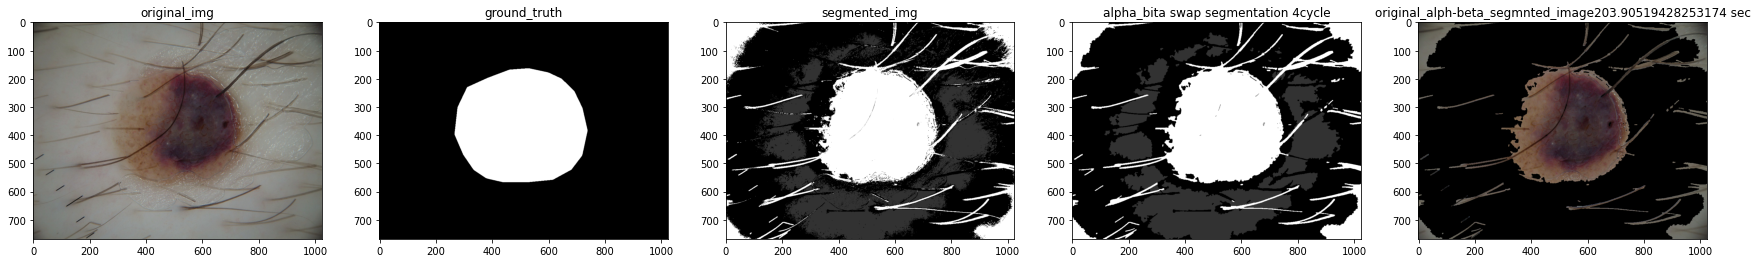

In [140]:
display = [original_pil,gt_img,seg_img,img_work,seg_img_orgnl]
label = ['original_img','ground_truth','segmented_img','alpha_bita swap segmentation %dcycle'%cycles,'original_alph-beta_segmnted_image%s sec'%(stop-start)]

fig2 = plt.figure(figsize=(30,35))

for i in range(len(display)):
  fig2.add_subplot(3,5, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()
# fig2.savefig("Output/op%d/alpha_beta segmentation ouput.png"%int(img_no+1))

# files.download("Output/op%d/alpha_beta segmentation ouput.png"%int(img_no+1))

In [141]:
# display = [gt_img,seg_img,img_work]
# label = ['ground_truth','segmented_img','alpha_bita swap segmentation',]

# fig = plt.figure(figsize=(20,25))

# for i in range(len(display)):
#   fig.add_subplot(3,3, i+1)
#   plt.imshow(display[i], cmap = 'gray')
#   plt.title(label[i])

# plt.show()

In [142]:
# np.unique(img_work)

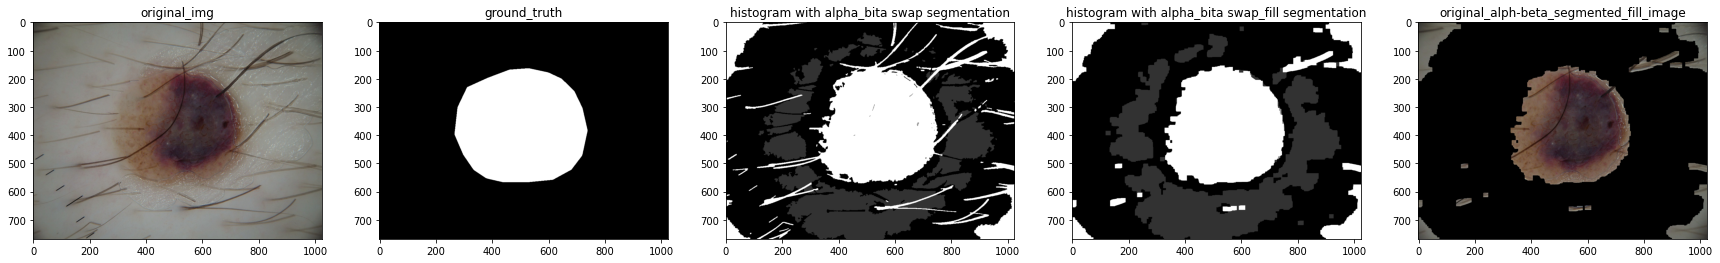

In [143]:

filterSize =(10,10) 
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                  filterSize)
opening1 = cv2.morphologyEx(np.float32(img_work), cv2.MORPH_OPEN, kernel1)
filterSize =(6,6) 
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                  filterSize)
dilation1 = cv2.dilate(opening1,kernel1,iterations = 1)
filterSize =(6,6) 
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                  filterSize)
closing1 = cv2.morphologyEx(dilation1, cv2.MORPH_CLOSE, kernel1)

seg_morph_img_orgnl = np.array(original_pil)
im_morph=np.array(closing1)
#seg_img_orgnl[:,:] = 0
ind_s_morph = np.where(im_morph!=255)
seg_morph_img_orgnl[ind_s_morph[0],ind_s_morph[1]] =0
display = [original_pil,gt_img,img_work,closing1,seg_morph_img_orgnl]
label = ['original_img','ground_truth','histogram with alpha_bita swap segmentation','histogram with alpha_bita swap_fill segmentation','original_alph-beta_segmented_fill_image']

fig3 = plt.figure(figsize=(30,35))

for i in range(len(display)):
  fig3.add_subplot(3,5, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()
# fig3.savefig("Output/op%d/alpha_beta segmentation ouput with morph.png"%int(img_no+1))

# files.download("Output/op%d/alpha_beta segmentation ouput with morph.png"%int(img_no+1))

ALPHA EXPANSION

ind_s_alpha1
ind_s_alpha_bar0
ind_s_alpha2
ind_s_alpha_bar0


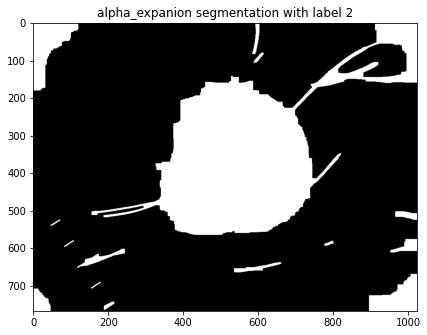

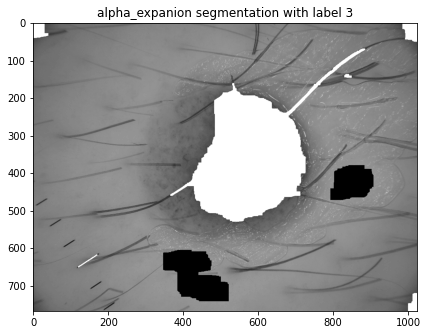

In [144]:
Label=[]
labels=[]
for L in range (2,4):
    #L=3
    list_img_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.jpg'))
    list_segmentation_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.png'))
    img = plt.imread(str(list_img_names[img_no]))
    I=rgb2gray(img)
    # I=cv2.resize(I,(int(I.shape[1]/2),int(I.shape[0]/2)))
    I = I[:,:]/I.max()

    # Generates 16 gray levels for nearsest prototype labeling
    #L = 3
    levs = np.arange(0.5/L, 1, 1/L)

    # Calculate data cost as the absolute difference between the label prototype and the pixel value
    D = np.abs(I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))

    # Generate nearest prototype labeling
    Id = np.argmin(D,2)

    # fg = plt.figure("Direct labeling")
    # ax1 = fg.add_subplot(1,1,1)
    # ax1.imshow(Id)

    # Calculate neighbourhood cost as absolute difference between prototypes 
    alpha = 1
    V = alpha * np.abs( levs.reshape((-1,1)) - levs.reshape((1,-1)))

    # Mimimise data + neighbourhood cost
    labels = aexpansion_grid(D,V)
    #labels=np.float32(labels)
    # labels=cv2.resize(labels,(int(labels.shape[1]/2),int(labels.shape[0]/2)))
    # labels=np.uint(labels)
    seg_alpha_img_orgnl = np.array(gray)
    im_labels=np.array(labels)
    #seg_img_orgnl[:,:] = 0
    ind_s_alpha = np.where(im_labels==np.max(labels))
    print('ind_s_alpha%d'%np.max(labels))
    ind_s_alpha_bar = np.where(im_labels==np.min(labels))
    print('ind_s_alpha_bar%d'%np.min(labels))
    seg_alpha_img_orgnl[ind_s_alpha[0],ind_s_alpha[1]] =0
    seg_alpha_img_orgnl[ind_s_alpha_bar[0],ind_s_alpha_bar[1]] =255
    Label.append((seg_alpha_img_orgnl))
    #Label.append(labels)
for i in range (len(Label)):

    fig = plt.figure(figsize=(18,18))

    # #for i in range(len(display)):
    fig.add_subplot(3,2, i+1)
    plt.imshow(Label[i],cmap='gray')
    plt.title('alpha_expanion segmentation with label %d'%(i+2))
    plt.show()
#choose the appropriate one

In [145]:
np.max(labels)

2

choose an sppropriate label

In [146]:
# np.unique(Label_uint8)
Label_uint8=np.uint8(Label[0])
# np.unique(Label_uint8)
# plt.imshow(Label_uint8,cmap='gray')

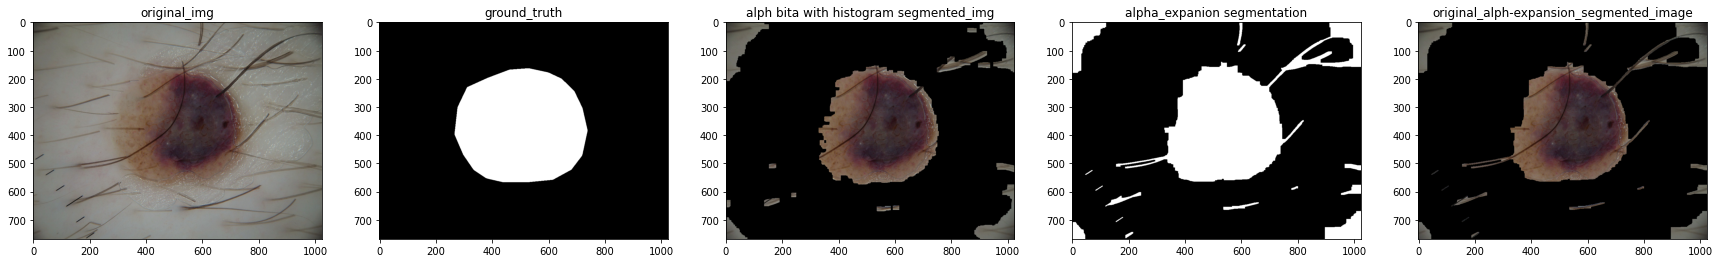

In [147]:
# # Display results
seg_alp_img_orgnl = np.array(original_pil)
im_alpha=np.array(Label_uint8)
#seg_img_orgnl[:,:] = 0
ind_s_morph = np.where(im_alpha!=255)
seg_alp_img_orgnl[ind_s_morph[0],ind_s_morph[1]] =0
display = [original_pil,gt_img,seg_morph_img_orgnl,Label_uint8,seg_alp_img_orgnl]
label = ['original_img','ground_truth','alph bita with histogram segmented_img','alpha_expanion segmentation','original_alph-expansion_segmented_image']

fig3 = plt.figure(figsize=(30,35))

for i in range(len(display)):
  fig3.add_subplot(3,5, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()
# fig3.savefig("Output/op%d/alpha_expansion segmentation ouput with real 10.png"%int(img_no+1))

# files.download("Output/op%d/alpha_expansion segmentation ouput with real 10.png"%int(img_no+1))

**Part 3: Compare the segmentation results with the ground truth using metrics [1] like accuracy, Dice similarity coefficient, Jaccard index (JAC), sensitivity, specificity.**



DICE similarity coefficient

In [148]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

  Jaccard coefficient

```
# This is formatted as code
```



In [149]:
def jc(result, reference):
    """
    Jaccard coefficient
    Parameters
    ----------
    result: array_like
            Input data containing objects. Can be any type but will be converted
            into binary: background where 0, object everywhere else.
    reference: array_like
            Input data containing objects. Can be any type but will be converted
            into binary: background where 0, object everywhere else.
    jc: float
        The Jaccard coefficient between the object(s) in `result` and the
        object(s) in `reference`. It ranges from 0 (no overlap) to 1 (perfect overlap).

    """
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    
    intersection = np.count_nonzero(result & reference)
    union = np.count_nonzero(result | reference)
    
    jc = float(intersection) / float(union) #tp/tp+fn+fp
    
    return jc


Sensitivity

In [150]:
def sensitivity(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
        
    tp = np.count_nonzero(result & reference)
    fn = np.count_nonzero(~result & reference)

    try:
        recall = tp / float(tp + fn)
    except ZeroDivisionError:
        recall = 0.0
    return recall


Specificity

In [151]:
def specificity(result, reference):
    """
    Specificity.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    
    Returns
    -------
    specificity : float
        The specificity between two binary datasets, here mostly binary objects in images,
        which denotes the fraction of correctly returned negatives. The
        specificity is not symmetric.

    """
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
       
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)

    try:
        specificity = tn / float(tn + fp)
    except ZeroDivisionError:
        specificity = 0.0
    
    return specificity

Accuracy

In [152]:
def accuracy (result, reference):
    # accuracy=(TP+TN)/(TP+FN+FP+TN)
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    tp=  np.count_nonzero(result & reference) 
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)
    fn = np.count_nonzero(~result & reference) 
    try:
        accuracy=(tp+tn)/(tp+tn+fp+fn)
    except ZeroDivisionError:
        accuracy = 0.0
    
    return accuracy

Segmentation result with histogram based clustering estimation only

In [153]:
# list_segmentation_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.png'))
# Original_Image=plt.imread(str(list_img_names[img_no]))
gt_img = plt.imread(str(list_segmentation_names[img_no]))
seg_img_binary = np.array(seg_img)
im_alpha=np.array(seg_img_binary)
seg_img_binary[:,:] = 0
ind_seg = np.where(im_alpha==255)
seg_img_binary[ind_seg[0],ind_seg[1]] =1
gt_img_int=np.uint8(gt_img)
# # seg_img_binary=np.uint8(seg_img_binary)
reference=np.array(gt_img_int)
result=np.array(seg_img_binary)
print('accuracy is: %f'%accuracy (result, reference))
 #accuracy (result, reference))
print('specificity is: %f'%specificity(result, reference))
print('sensitivity is: %f'%sensitivity(result, reference))
print('Jaccard coefficient is: %f'%jc(result, reference))
print('Dice coefficient is: %f'%dice(result, reference))


accuracy is: 0.867415
specificity is: 0.874022
sensitivity is: 0.840029
Jaccard coefficient is: 0.551859
Dice coefficient is: 0.711223


Segmentation result with histogram based clustering estimation with alpha bita graph cut segmentation

In [154]:
# list_segmentation_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.png'))
# Original_Image=plt.imread(str(list_img_names[img_no]))
# gt_img = plt.imread(str(list_segmentation_names[img_no]))
seg_img_albi_binary = np.array(closing1)
im_alpha=np.array(seg_img_albi_binary)
seg_img_albi_binary[:,:] = 0
ind_seg = np.where(im_alpha==255)
seg_img_albi_binary[ind_seg[0],ind_seg[1]] =1
gt_img_int=np.uint8(gt_img)
# # seg_img_binary=np.uint8(seg_img_binary)
reference=np.array(gt_img_int)
result=np.array(seg_img_albi_binary)
print('accuracy is: %f'%accuracy (result, reference))
 #accuracy (result, reference))
print('specificity is: %f'%specificity(result, reference))
print('sensitivity is: %f'%sensitivity(result, reference))
print('Jaccard coefficient is: %f'%jc(result, reference))
print('Dice coefficient is: %f'%dice(result, reference))

accuracy is: 0.893978
specificity is: 0.904894
sensitivity is: 0.848730
Jaccard coefficient is: 0.608751
Dice coefficient is: 0.756800


Segmentation result with alpha expansion method only

In [155]:
seg_img_aexp_binary = np.array(Label_uint8)
im_alpha=np.array(seg_img_aexp_binary)
seg_img_aexp_binary[:,:] = 0
ind_seg = np.where(im_alpha!=0)
seg_img_aexp_binary[ind_seg[0],ind_seg[1]] =1
gt_img_int=np.uint8(gt_img)
reference=np.array(gt_img)
result=np.array(seg_img_aexp_binary)
print('accuracy is: %f'%accuracy (result, reference))
 #accuracy (result, reference))
print('specificity is: %f'%specificity(result, reference))
print('sensitivity is: %f'%sensitivity(result, reference))
print('Jaccard coefficient is: %f'%jc(result, reference))
print('Dice coefficient is: %f'%dice(result, reference))

accuracy is: 0.903885
specificity is: 0.918466
sensitivity is: 0.843444
Jaccard coefficient is: 0.630396
Dice coefficient is: 0.773304
